# Explore VCI Predictions

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in config file and predictions

In [3]:
ds = pickle.load((base_dir / "data/kenya.pkl").open("rb"))
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    boku_VCI    (time, lat, lon) float64 43.72 31.13 85.88 20.18 ... nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.4688 0.4032 0.624 ... nan nan nan
    VCI         (time, lat, lon) float64 39.64 37.79 89.79 53.54 ... nan nan nan
    precip      (time, lat, lon) float64 13.66 18.42 24.78 47.38 ... nan nan nan
    E           (time, lat, lon) float64 52.86 64.59 64.59 75.49 ... nan nan nan
    Eb          (time, lat, lon) float64 2.3 2.311 2.311 2.409 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2993 0.3273 0.3273 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2837 0.309 0.309 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.121e-05 3.69e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.007123 -0.007165 ... nan nan
    sp          (time, lat, lon) float64 9.591e+04 9.604e+04 ... nan nan
    t2m         (time, lat, lon) float64 303.0 303.8 302.2 299.3 ... nan nan nan
    tp          (time, lat, lon) float64 0.0004198 0.0003483 ... nan nan

In [4]:
RUN = "kenya_static_0503_112513"

run_dir = base_dir / f"runs/{RUN}/"
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir
cfg

{'autoregressive': False,
 'batch_size': 100,
 'clip_gradient_norm': None,
 'constant_mean': None,
 'constant_std': None,
 'data_dir': PosixPath('data/kenya.pkl'),
 'device': 'cuda:0',
 'dropout': 0.4,
 'early_stopping': 10,
 'encode_doys': True,
 'experiment_name': 'kenya_static',
 'forecast_variables': None,
 'hidden_size': 32,
 'horizon': 0,
 'input_variables': ['precip', 't2m', 'SMsurf', 'pev'],
 'learning_rate': 0.001,
 'loss': 'huber',
 'model': 'lstm',
 'n_epochs': 10,
 'num_workers': 4,
 'optimizer': 'AdamW',
 'pixel_dims': ['lat', 'lon'],
 'run_dir': PosixPath('/Users/tommylees/github/spatio_temporal/runs/kenya_static_0503_112513'),
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 3,
 'static_inputs': 'embedding',
 'target_variable': 'boku_VCI',
 'test_end_date': Timestamp('2020-12-31 00:00:00'),
 'test_start_date': Timestamp('2016-01-31 00:00:00'),
 'time_str': 'time',
 'train_end_date': Timestamp('2015-12-31 00:00:00'),
 'train_start_date': Timestamp('2002-01-01 00:00:00

In [5]:
import pickle 

normalizer = pickle.load((run_dir / "normalizer.pkl").open("rb"))

# Are the train Test Periods equivalent?
- test period has worse vegetation health

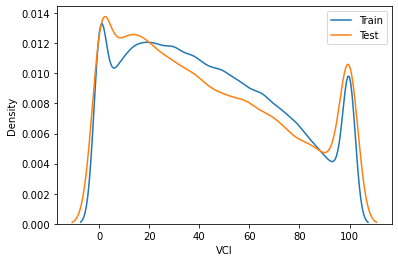

In [6]:
test = ds.sel(time=slice(cfg._cfg["test_start_date"], cfg._cfg["test_end_date"]))
train = ds.sel(time=slice(cfg._cfg["train_start_date"], cfg._cfg["train_end_date"]))

train_target = train[cfg.target_variable].values.flatten()
test_target = test[cfg.target_variable].values.flatten()

sns.kdeplot(train_target, label="Train")
sns.kdeplot(test_target, label="Test")
plt.gca().set_xlabel("VCI")
plt.legend()

# Check loss curves

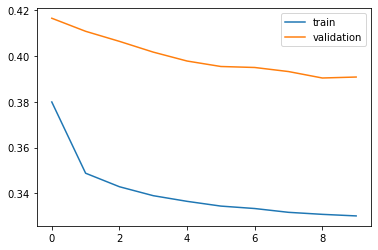

In [7]:
assert (cfg.run_dir / "losses.csv").exists(), f"{list((cfg.run_dir).iterdir())}" 

losses = pd.read_csv(cfg.run_dir / "losses.csv", index_col=0)

losses.plot()

# Explore Predictions

In [9]:
xr_path = sorted(list(run_dir.glob("test*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon")
preds

<xarray.Dataset>
Dimensions:  (pixel: 1412, time: 32)
Coordinates:
  * time     (time) datetime64[ns] 2016-04-30T00:00:31.965380608 ... 2018-11-...
  * pixel    (pixel) object '-0.25_34.25' '-0.25_34.5' ... '6.0_42.25'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

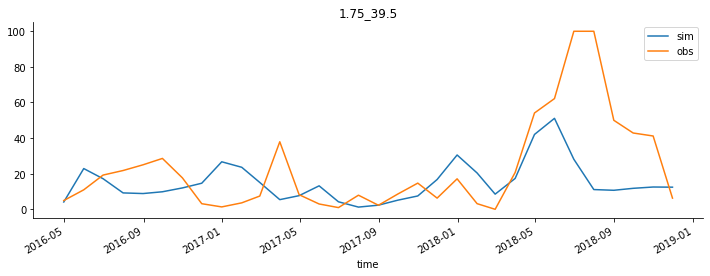

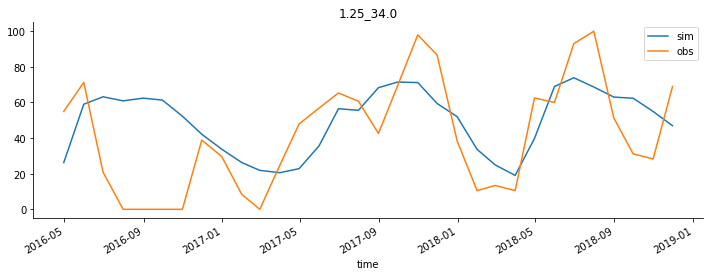

In [68]:
from spatio_temporal.training.eval_utils import save_timeseries

for _ in range(2):
    save_timeseries(preds, cfg)
    sns.despine()

Text(0.5, 1.0, 'Test Performance')

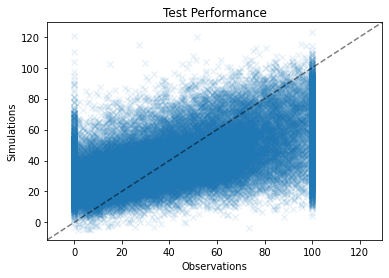

In [10]:
from spatio_temporal.training.eval_utils import _plot_scatter
f, ax = _plot_scatter(preds);
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 100)
ax.set_title("Test Performance")

In [11]:
r2 = float(xr.corr(preds["obs"], preds["sim"]).values)

error = preds["obs"] - preds["sim"]
rmse = np.sqrt(((error)**2).mean(xr.ALL_DIMS))
rmse = float(rmse.values)

print(f"R2 score: \t{r2:.2f}")
print(f"RMSE score: \t{rmse:.2f}")

R2 score: 	0.57
RMSE score: 	26.01


In [12]:
cfg._cfg["device"] = "cpu"
trainer = Trainer(cfg, ds)

/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tommylees/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Loading Data: 100%|██████████| 1575/1575 [00:03<00:00, 496.90it/s]


In [13]:
dataset = trainer.train_dl.dataset
dataset.__getitem__(1)

{'meta': {'index': 1, 'target_time': tensor(1.0228e+18)},
 'x_d': tensor([[-0.0945,  0.4409, -0.9261,  0.0150, -0.4775, -0.8786],
         [-0.6108,  0.6192, -0.6555, -0.7330, -0.8827,  0.4700],
         [-0.4451,  0.3918,  0.1016, -0.4887,  0.4925,  0.8703]]),
 'y': tensor([[-0.4572]]),
 'x_s': tensor([1., 0., 0.,  ..., 0., 0., 0.]),
 'x_f': tensor([], dtype=torch.float64)}

# Check performance on train data

In [14]:
cfg.run_dir = run_dir
tester = Tester(cfg, ds, subset="train")

Loading Data: 100%|██████████| 1575/1575 [00:07<00:00, 207.19it/s]


Test set Forward Pass: 100%|██████████| 2330/2330 [00:22<00:00, 103.88it/s]


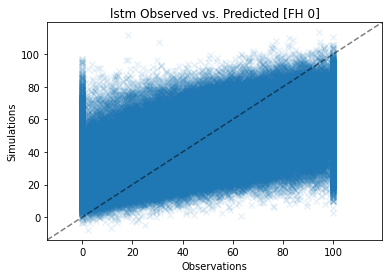

In [15]:
train_preds = tester.run_test(save_preds=False)

Text(0.5, 1.0, 'Train Performance')

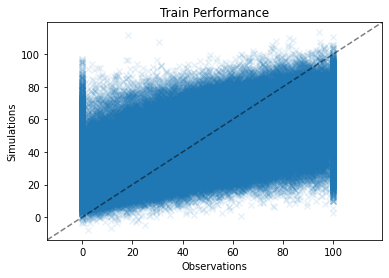

In [16]:
f, ax = _plot_scatter(train_preds);
ax.set_title("Train Performance")

In [17]:
r2 = float(xr.corr(train_preds["obs"], train_preds["sim"]).values)

error = train_preds["obs"] - train_preds["sim"]
rmse = np.sqrt(((error)**2).mean(xr.ALL_DIMS))
rmse = float(rmse.values)

print(f"R2 score: \t{r2:.2f}")
print(f"RMSE score: \t{rmse:.2f}")

R2 score: 	0.58
RMSE score: 	24.00


# Calculate all errors

In [18]:
# from ml_drought
import sys; sys.path.append("/Users/tommylees/github/ml_drought")
import sys; sys.path.append("/Users/tommylees/github/neuralhydrology")
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from spatio_temporal.data.data_utils import unstack_xarray


errors = calculate_all_data_errors(
    preds.rename({"pixel":"station_id"}), decompose_kge=False, yilmaz_errors=True
)["sim"].to_xarray().rename({"station_id": "pixel"})
spatial_errors = unstack_xarray(errors, sample_str="pixel")

Errors:   0%|          | 0/1 [00:00<?, ?it/s]/Users/tommylees/github/ml_drought/scripts/drafts/water_closure_levels.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year, 1, 1).year
/Users/tommylees/github/ml_drought/scripts/drafts/water_closure_levels.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime(dt.year + 1, 1, 1).year
/Users/tommylees/github/ml_drought/scripts/drafts/calculate_error_scores.py:109: RuntimeWarning: invalid value encountered in log
  np.log(d["obs"].values + epsilon), np.log(d["sim"].values + epsilon)
/Users/tommylees/github/ml_drought/scripts/drafts/calculate_error_scores.py:117: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(d["obs"].values), np.sqrt(d["sim"].values)
/Users/tommylees/github/neuralhydrolog

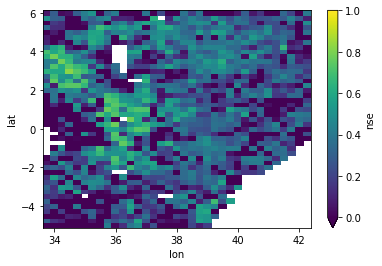

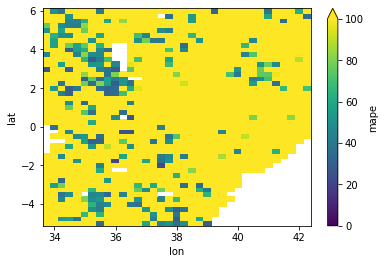

In [35]:
f, ax = plt.subplots()
spatial_errors["nse"].plot(vmin=0, vmax=1);

f, ax = plt.subplots()
spatial_errors["mape"].plot(vmin=0, vmax=100);

In [24]:
print(list(spatial_errors.data_vars))

['pixel', 'nse', 'kge', 'mse', 'bias', 'pbias', 'log_nse', 'inv_kge', 'sqrt_kge', 'abs_pct_bias', 'mape', 'bias_error', 'std_error', 'fms', 'flv', 'fhv', 'mam30_ape', 'rmse']


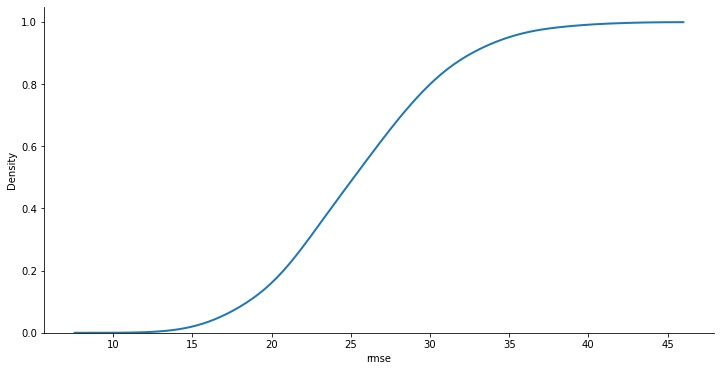

In [67]:
f, ax = plt.subplots(figsize=(12, 6))
# sns.histplot(errors["rmse"], ax=ax, kde=True)
sns.kdeplot(errors["rmse"], ax=ax, cumulative=True, clip=(0, 46), **dict(linewidth=2));
sns.despine()

# ARIMA

In [ ]:
assert False, "Experimental work"

In [ ]:
from spatio_temporal.data.data_utils import _stack_xarray

# Get the timeseries 
TARGET = cfg.target_variable
TARGET = "boku_VCI"
stacked, _ = _stack_xarray(ds[TARGET], spatial_coords=cfg.pixel_dims)
stacked = stacked.dropna(how="all", dim="sample")

train_ds = stacked.sel(time=slice(cfg.train_start_date, cfg.train_end_date))
test_ds = stacked.sel(time=slice(cfg.test_start_date, cfg.test_end_date))

pixel = np.random.choice(stacked.sample)
tgt_mean = train_ds.mean(dim="sample").to_dataframe()[TARGET]
tgt = train_ds.sel(sample=pixel).to_dataframe()[TARGET]

test_tgt = test_ds.sel(sample=pixel).to_dataframe()[TARGET]

In [ ]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title(f'{TARGET} Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(tgt, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

In [ ]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(tgt.dropna(), alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(tgt.dropna(), alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

if n_diffs > 0:
    print(f"Estimated differencing term: {n_diffs}")
else:
    print(f"Time series is judged constant")

### remove seasonality?

In [ ]:
from pmdarima import preprocessing as ppc
# print(dir(ppc))
transformer = ppc.FourierFeaturizer(m=12, k=3)

transformer.fit(tgt)
transformed_target, fourier = transformer.fit_transform(tgt)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

display(transformed_target[:5])
display(tgt[:5])

f, axs = plt.subplots(2, 1, figsize=(12, 2*2), sharex=True, sharey=True)
tgt.plot(ax=axs[0])
transformed_target.plot(ax=axs[1])

In [ ]:


fourier_features = len(fourier.columns)
f, axs = plt.subplots(fourier_features, 1, figsize=(12, 1*fourier_features), sharex=True, sharey=True)

for ix in np.arange(fourier_features):
    ax = axs[ix]
    fourier.iloc[:, ix].plot(ax=ax, color=f"C{ix}")
    ax.set_title(fourier.iloc[:, ix].name)

plt.tight_layout()